In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

X_train = pd.read_csv('/content/drive/MyDrive/Colab/X_train.csv')
Y_train = pd.read_csv('/content/drive/MyDrive/Colab/y_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab/X_test.csv')
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (3794, 9000)
Shape of Y_train: (3794, 2)
Shape of X_test: (670, 9000)


In [ ]:
print(X_train.info())
print()
print(Y_train.info())
print()
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Columns: 9000 entries, LINC01128 to AC007325.4
dtypes: float64(9000)
memory usage: 260.5 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794 entries, 0 to 3793
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        3794 non-null   int64  
 1   Expected  3794 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.4 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Columns: 9000 entries, LINC01128 to AC007325.4
dtypes: float64(9000)
memory usage: 46.0 MB
None


## Eksploracja danych

### Sprawdzenie kształtu danych
Pierwszym krokiem w eksploracji danych jest sprawdzenie liczby obserwacji i zmiennych w zbiorach danych treningowych i testowych.


Od razu dzielę zbiory X i Y na treningowy i walidacyjny, aby używać takich podziałów, w każdym modelu.

In [ ]:
print("Missing values in X_train:\n", X_train.isnull().sum().sum())
print("Missing values in Y_train:\n", Y_train.isnull().sum().sum())
print("Missing values in X_test:\n", X_test.isnull().sum().sum())


Missing values in X_train:
 0
Missing values in Y_train:
 0
Missing values in X_test:
 0


### Sprawdzanie Brakujących Wartości

Ważne jest, aby upewnić się, że w zbiorach danych nie ma brakujących wartości przed przystąpieniem do dalszej analizy.


                Id     Expected
count  3794.000000  3794.000000
mean   1896.500000     0.789212
std    1095.377789     0.867207
min       0.000000     0.000000
25%     948.250000     0.000000
50%    1896.500000     0.303113
75%    2844.750000     1.667722
max    3793.000000     2.869365


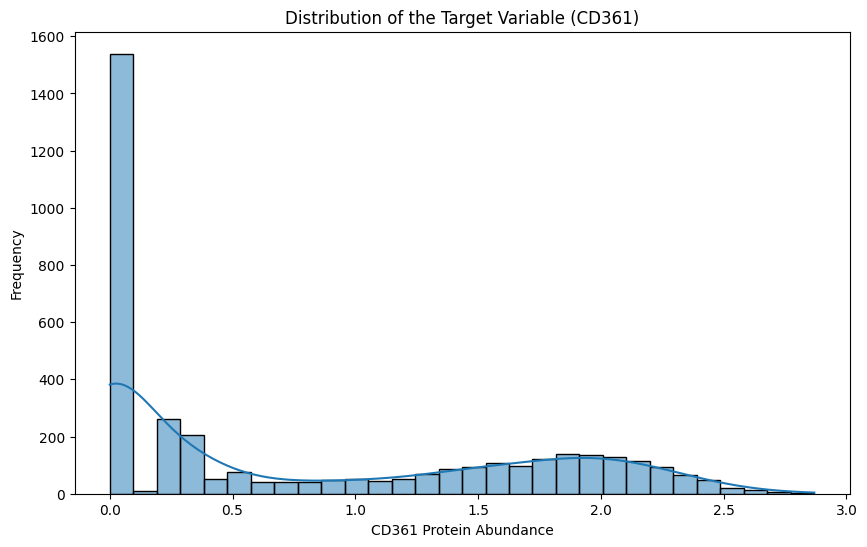

In [ ]:
print(Y_train.describe())

plt.figure(figsize=(10, 6))
sns.histplot(Y_train.iloc[:, 1], bins=30, kde=True)
plt.title('Distribution of the Target Variable (CD361)')
plt.xlabel('CD361 Protein Abundance')
plt.ylabel('Frequency')
plt.show()


### Empiryczny Rozkład Zmiennej Objaśnianej

Następnie zbadamy empiryczny rozkład zmiennej objaśnianej (ilość białka CD361) poprzez wygenerowanie podstawowych statystyk oraz histogramu.

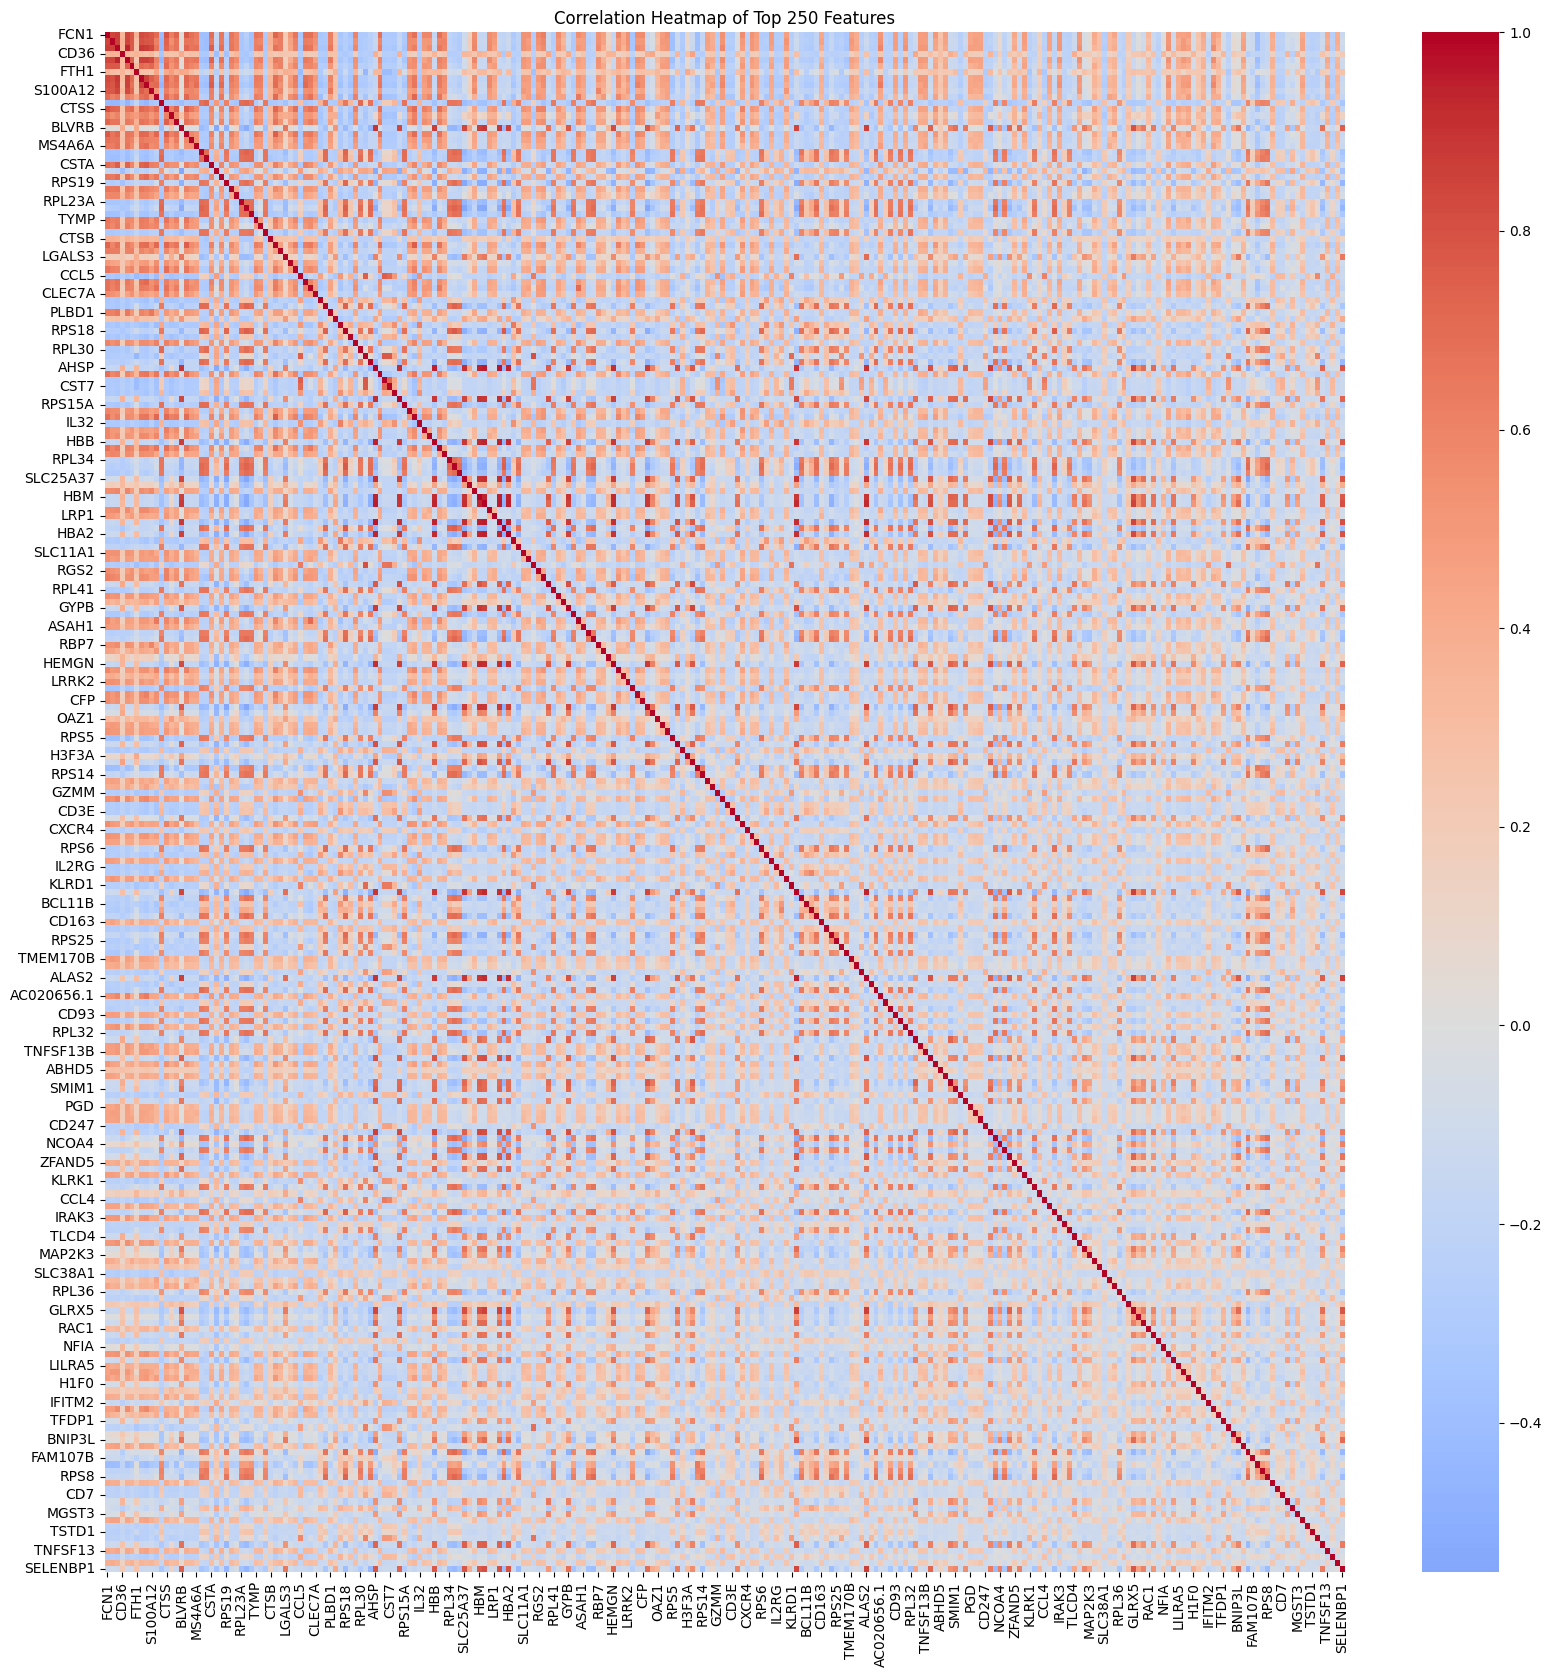

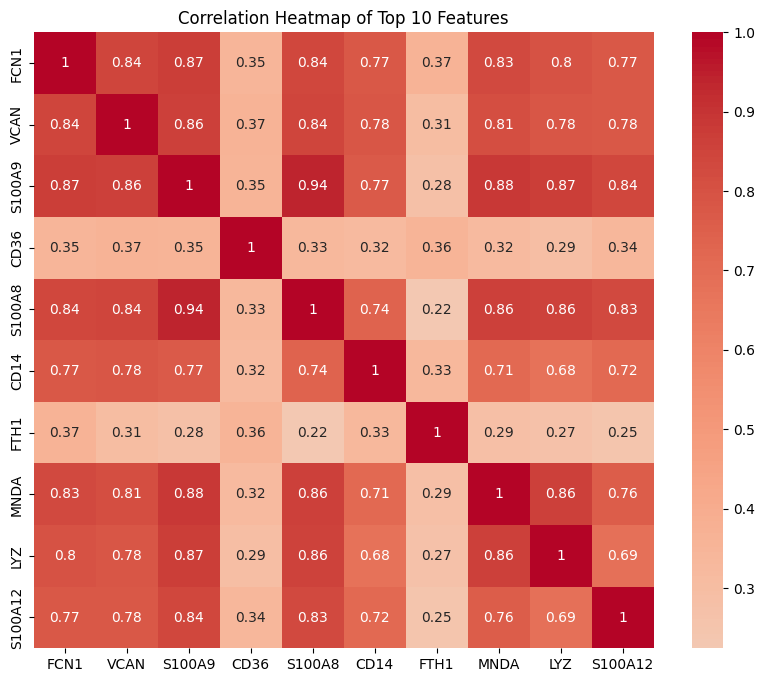

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


correlations = X_train.corrwith(Y_train['Expected'])

top_250_features = correlations.abs().sort_values(ascending=False).head(250).index

X_train_top_250 = X_train[top_250_features]

correlation_matrix = X_train_top_250.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Top 250 Features')
plt.show()

top_10_features = correlations.abs().sort_values(ascending=False).head(10).index

X_train_top_10 = X_train[top_10_features]

correlation_matrix = X_train_top_10.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Top 10 Features')
plt.show()



Analiza Korelacji

Aby zrozumieć związek między cechami a zmienną objaśnianą, obliczymy korelację każdej cechy ze zmienną objaśnianą. Następnie wybierzemy 250 cech najbardziej skorelowanych ze zmienną objaśnianą i zwizualizujemy macierz korelacji za pomocą mapy ciepła (heatmapy).

Poniżej wybrałem 10 najbadziej skorelowanych ze zmienną objaśniającą cech i pokazałem ich heat-mapę, gdyż ta potężna 250x250 heat mapa może być nie czytelna i zaciemnić to co najważniejsze.

##Model ElasticNet
###Informacje o modelu ElasticNet

ElasticNet jest modelem regresyjnym, który łączy cechy regresji grzbietowej (ridge regression) i regresji lasso (least absolute shrinkage and selection operator). Jest używany głównie do celów regularyzacji, aby zapobiec przetrenowaniu modelu oraz radzić sobie z wysoką korelacją między cechami.
###Parametry modelu ElasticNet

ElasticNet ma kilka kluczowych parametrów, które są estymowane podczas treningu modelu:

  Koeficjenty regresji (wagi) β: Są to wartości przypisane do poszczególnych cech (feature coefficients) w celu minimalizacji błędu modelu.

  Intercept (α): Jest to wartość, która jest dodawana do sumy ważonych cech, reprezentująca punkt przecięcia osi Y przez linię regresji.

###Optymalizowana funkcja

Funkcja optymalizowana przez ElasticNet jest kombinacją funkcji kosztu dla regresji lasso i regresji grzbietowej:

$$ \min_{\beta} \left( \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} X_{ij} \beta_j \right)^2 + \alpha \left( \frac{1 - l1\_ratio}{2} \sum_{j=1}^{p} \beta_j^2 + l1\_ratio \sum_{j=1}^{p} |\beta_j| \right) \right)$$


gdzie:

  y_i to rzeczywista wartość zmiennej zależnej dla obserwacji i,
  X_ij to wartość cechy j dla obserwacji i,
  β_0 to wyraz wolny (intercept),
  β_j to waga cechy j,
  α to parametr regularyzacji,
  l1_ratio to współczynnik kontrolujący balans między regularyzacją L1 (lasso) i L2 (ridge).

###Hiperparametry

ElasticNet zależy od dwóch głównych hiperparametrów:

  Alpha (α): Określa siłę regularyzacji. Wyższe wartości α zwiększają wpływ regularyzacji, co prowadzi do mniejszych wartości wag i prostszych modeli.

  L1 ratio (l1_ratio): Określa balans między regularyzacją L1 (lasso) i L2 (ridge).
        l1_ratio=1 oznacza czystą regularyzację L1 (lasso),
        l1_ratio=0 oznacza czystą regularyzację L2 (ridge),
        0<l1_ratio<1 oznacza kombinację obu rodzajów regularyzacji.

###Regresja grzbietowa (Ridge Regression)

Regresję grzbietową otrzymujemy, gdy l1_ratio=0. W takim przypadku funkcja kosztu redukuje się do:

$$\min_{\beta} \left( \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} X_{ij} \beta_j \right)^2 + \alpha \left( \frac{1}{2} \sum_{j=1}^{p} \beta_j^2 \right) \right) $$
###Regresja lasso (Lasso Regression)

Regresję lasso otrzymujemy, gdy l1_ratio=1. W takim przypadku funkcja kosztu redukuje się do:

$$\min_{\beta} \left( \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} X_{ij} \beta_j \right)^2 + \alpha \left( \sum_{j=1}^{p} |\beta_j| \right) \right)$$
###Podsumowanie

ElasticNet jest wszechstronnym modelem regresyjnym, który łączy zalety regresji grzbietowej i lasso, dostosowując balans między nimi za pomocą hiperparametru l1_ratio. Optymalizowana funkcja zawiera zarówno termin L1, jak i L2, co pozwala na elastyczne regulowanie modelu w zależności od potrzeb, takich jak sparsowanie cech czy radzenie sobie z kolinearnością.

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform

elastic_net = ElasticNet()

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', elastic_net)
])

param_dist = {
    'elasticnet__alpha': uniform(0.1, 2.0),
    'elasticnet__l1_ratio': uniform(0.1, 0.9)
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, Y_train['Expected'])

best_params = random_search.best_params_
best_score = -random_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score (RMSE):", np.sqrt(best_score))

best_model = random_search.best_estimator_

train_predictions = best_model.predict(X_train)
train_rmse = np.sqrt(np.mean((train_predictions - Y_train['Expected'].values.ravel())**2))

print("Training RMSE:", train_rmse)


Best parameters: {'elasticnet__alpha': 0.412037280884873, 'elasticnet__l1_ratio': 0.2403950683025824}
Best cross-validation score (RMSE): 0.43685618871020265
Training RMSE: 0.433523052540178


In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

elastic_net = ElasticNetCV(l1_ratio=[.2, .5, .8], alphas=[.1, .01], cv=3, n_jobs=-1)

elastic_net.fit(X_train, Y_train['Expected'])

best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_
print(f'Best alpha: {best_alpha}')
print(f'Best l1_ratio: {best_l1_ratio}')

Best alpha: 0.01
Best l1_ratio: 0.5


In [ ]:
train_pred = elastic_net.predict(X_train)
train_error = mean_squared_error(Y_train['Expected'], train_pred)

elastic_net.fit(X_train_split, Y_train_split['Expected'])
val_pred = elastic_net.predict(X_val_split)
val_error = mean_squared_error(Y_val_split['Expected'], val_pred)

print(f'Training Error (ElasticNet): {train_error}')
print(f'Validation Error (ElasticNet): {val_error}')

Training Error (ElasticNet): 0.1040502946431381
Validation Error (ElasticNet): 0.11264296565587474


In [ ]:
best_model = elastic_net

train_predictions = best_model.predict(X_train)

train_rmse = np.sqrt(np.mean((train_predictions - Y_train['Expected'].values.ravel())**2))
print("Training RMSE:", train_rmse)

Training RMSE: 0.32141295449938545


###Trenowanie innych modeli
Trenowanie modelu ElasticNet z GridSearchem jest bardzo czasochłonne, więc na początku trenuje prostsze modele. Zaczynam od eksploracyjnego wytrenowania modelu RandomisedCV, a potem ElasticNet, ale bez GridSearcha.

To da mi punkt odniesienia co do wielkości błędu i wielkości hiperparametrów.

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

param_grid = {
    'alpha': [10, 50, 100],
    'l1_ratio': [0, 0.5, 1]  # 0 -> Ridge, 0.5 -> ElasticNet, 1 -> Lasso
}

elastic_net = ElasticNet()
grid_search_big_a = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_big_a.fit(X_train, Y_train['Expected'])

print(f'Best parameters (ElasticNet): {grid_search_big_a.best_params_}')

Best parameters (ElasticNet): {'alpha': 10, 'l1_ratio': 0}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.617e+02, tolerance: 2.853e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [ ]:
best_elastic_net = grid_search_big_a.best_estimator_
train_pred = best_elastic_net.predict(X_train)
train_error = mean_squared_error(Y_train['Expected'], train_pred)

best_elastic_net.fit(X_train_split, Y_train_split['Expected'])
val_pred = best_elastic_net.predict(X_val_split)
val_error = mean_squared_error(Y_val_split['Expected'], val_pred)

print(f'Training Error (ElasticNet): {train_error}')
print(f'Validation Error (ElasticNet): {val_error}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.520e+02, tolerance: 2.281e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Training Error (ElasticNet): 0.1952941962708217
Validation Error (ElasticNet): 0.190265169303875


In [ ]:
best_model = best_elastic_net

train_predictions = best_model.predict(X_train)

train_rmse = np.sqrt(np.mean((train_predictions - Y_train['Expected'].values.ravel())**2))
print("Training RMSE:", train_rmse)

Training RMSE: 0.4413481406285105


###Wnioski
Po puszczeniu Randomised i Elastic bez Grida widzę, że małe wartości alpha są preferowane, ale dla pewności odpalę najpierw GridSearcha dla dużych wartości alpha - tak dla pewności.

Następnie przejdę do wytrenowania najlepszego modelu, czyli GridSearch, małe alpha.

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

param_grid = {
    'alpha': [0.1, 0.5, 1],
    'l1_ratio': [0, 0.5, 1]  # 0 -> Ridge, 0.5 -> ElasticNet, 1 -> Lasso
}

elastic_net = ElasticNet()
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, Y_train['Expected'])

print(f'Best parameters (ElasticNet): {grid_search.best_params_}')

Best parameters (ElasticNet): {'alpha': 0.5, 'l1_ratio': 0}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e+02, tolerance: 2.853e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [ ]:
best_elastic_net = grid_search.best_estimator_
train_pred = best_elastic_net.predict(X_train)
train_error = mean_squared_error(Y_train['Expected'], train_pred)

best_elastic_net.fit(X_train_split, Y_train_split['Expected'])
val_pred = best_elastic_net.predict(X_val_split)
val_error = mean_squared_error(Y_val_split['Expected'], val_pred)

print(f'Training Error (ElasticNet): {train_error}')
print(f'Validation Error (ElasticNet): {val_error}')

Training Error (ElasticNet): 0.07925080507293308
Validation Error (ElasticNet): 0.1157973839412198


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e+02, tolerance: 2.281e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [ ]:
best_model = best_elastic_net

train_predictions = best_model.predict(X_train)

train_rmse = np.sqrt(np.mean((train_predictions - Y_train['Expected'].values.ravel())**2))
print("Training RMSE:", train_rmse)

Training RMSE: 0.2864051601773629


##Model Random Forest
###Wyjaśnienie Modelu

Random Forest to metoda uczenia zespołowego stosowana do klasyfikacji i regresji, która konstruuje wiele drzew decyzyjnych podczas treningu i wyznacza średnią predykcję poszczególnych drzew. Pomaga to poprawić dokładność predykcji i kontrolować nadmierne dopasowanie modelu (over-fitting).

Teraz wytrenujemy model Random Forest i dostroimy jego hiperparametry za pomocą walidacji krzyżowej.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, Y_train['Expected'])

best_rf = grid_search.best_estimator_

print(f'Best parameters (Random Forest): {grid_search.best_params_}')


Best parameters (Random Forest): {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 30}


###Strojenie Hiperparametrów dla Random Forest

Użyjemy GridSearchCV, aby znaleźć najlepszą kombinację hiperparametrów dla modelu Random Forest. Przeszukiwanie siatki (grid search) będzie eksplorować następujące wartości parametrów:

    'n_estimators': [10, 20, 30],
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 5, 10]

Najlepsze parametry oraz odpowiadający im wynik walidacji krzyżowej zostaną wydrukowane.

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

val_pred_rf = best_rf.predict(X_val_split)
val_error_rf = mean_squared_error(Y_val_split['Expected'], val_pred_rf)
train_pred = best_rf.predict(X_train)
train_error = mean_squared_error(Y_train['Expected'], train_pred)

print(f'Training Error (Random Forest): {train_error}')
print(f'Validation Error (Random Forest): {val_error_rf}')

train_predictions_rf = best_rf.predict(X_train)

train_rmse_rf = np.sqrt(np.mean((train_predictions_rf - Y_train['Expected'].values.ravel())**2))
print("Training RMSE (Random Forest):", train_rmse_rf)


Training Error (Random Forest): 0.07274375592047863
Validation Error (Random Forest): 0.07539292484251241
Training RMSE (Random Forest): 0.26971050391202533


###Błąd Trenowania i Walidacji dla Random Forest

Używając najlepszych hiperparametrów znalezionych za pomocą grid search, wytrenujemy model Random Forest na danych treningowych i obliczymy błąd trenowania (RMSE).

In [ ]:
mean_y_train = Y_train['Expected'].mean()
baseline_pred = np.full_like(Y_val_split['Expected'], mean_y_train)
baseline_error = mean_squared_error(Y_val_split['Expected'], baseline_pred)
baseline_rmse = np.sqrt(baseline_error)

results = pd.DataFrame({
    'Model': ['ElasticNet', 'Random Forest', 'Baseline'],
    'Validation Error': [val_error, val_error_rf, baseline_error],
    'Training RMSE': [train_rmse, train_rmse_rf, baseline_rmse]
})
print(results)

best_model = results.loc[results['Validation Error'].idxmin()]
print(f'Best model: {best_model["Model"]} with Validation Error: {best_model["Validation Error"]}')


           Model  Validation Error  Training RMSE
0     ElasticNet          0.115797       0.286405
1  Random Forest          0.075393       0.269711
2       Baseline          0.752760       0.867617
Best model: Random Forest with Validation Error: 0.07539292484251241


###Porównanie Modelu referencyjnego, Modelu ElasticNet i Random Forest

Podsumujemy wydajność wszystkich modeli za pomocą tabeli, która będzie zawierała błąd walidacyjny i błąd RMSE.

##Predykcja na zbiorze testowym
Wyżej pokazałem porównanie błędu walidacyjnego i rmse w modelach. Jak widać najlepiej radzi sobie model random forest, dlatego to właśnie jego użyje do zrobienia predykcji na zbiorze X_test. Zapisuję je do pliku 448533_prediction.csv.

In [6]:
test_pred = best_rf.predict(X_test)

submission = pd.DataFrame({
    'Id': X_test.index,
    'Expected': test_pred
})
submission.to_csv('448533_prediction.csv', index=False)

print("Predykcje zostały zapisane do pliku '448533_prediction.csv'")

Predykcje zostały zapisane do pliku '448533_prediction.csv'
